We have created this notebook to explore the issues with the custom Fourier loss function we previously created 
$loss = \frac{\beta}{N}\sum_{k=0}^N |f_{target}(x) - f_{output}(x)| ^2 + \alpha \frac{1}{N}\sum_{k=0}^N |F_{target}(k) - F_{output}(k)| ^2$, \
where \
$\hat{F}(k) = \frac{F(k)}{max |F(k)|}$ and $F(k) = \int_{-\infty}^\infty f(x) e^{-2\pi ikx} dx$

We have generated data that has a few randomly generated Gaussians as CNN input data. The output data takes the form \
$output = 2 * input$

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

import scipy
from scipy.fft import fft2, ifft2, fftshift, ifftshift

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from model_eval_plotting import evaluate_model
from model_eval_plotting import plot_predictions_vs_targets

from CNN_setup import SimpleCNN
from CNN_setup import TensorDataset

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.fft


## Data Generation and Pre-Processing

In [2]:
def generate_gaussian_image(size=50, num_gaussians=3):
    """Generate a single image with multiple Gaussian blobs."""
    img = np.zeros((size, size))
    
    for _ in range(num_gaussians):
        x0, y0 = np.random.randint(0, size, size=2)  # Random center
        sigma_x, sigma_y = np.random.uniform(3, 10, size=2)  # Random spread
        
        x = np.arange(size)
        y = np.arange(size)
        X, Y = np.meshgrid(x, y)
        
        gaussian = np.exp(-(((X - x0)**2 / (2 * sigma_x**2)) + ((Y - y0)**2 / (2 * sigma_y**2))))
        img += gaussian
    
    img = img / np.max(img)  # Normalize to [0,1]
    return img

def generate_dataset(num_images=100, size=50):
    """Generate multiple Gaussian images and store them in an xarray dataset."""
    images = np.array([generate_gaussian_image(size) for _ in range(num_images)])
    dataset = xr.DataArray(images, dims=["image", "x", "y"], name="gaussian_images")
    return dataset

# Generate dataset
dataset_in = generate_dataset()
dataset_in

<xarray.DataArray 'gaussian_images' (image: 100, x: 50, y: 50)> Size: 2MB
array([[[1.18036753e-11, 1.28635464e-11, 1.38774871e-11, ...,
         1.99872800e-01, 1.26985535e-01, 7.42910901e-02],
        [5.98045891e-11, 6.51745401e-11, 7.03117798e-11, ...,
         2.33050291e-01, 1.48064249e-01, 8.66228933e-02],
        [2.86789368e-10, 3.12540651e-10, 3.37175980e-10, ...,
         2.65390082e-01, 1.68610745e-01, 9.86433298e-02],
        ...,
        [9.50027592e-01, 9.77461921e-01, 9.94308361e-01, ...,
         1.66507681e-05, 1.00518622e-05, 6.00088540e-06],
        [9.08651124e-01, 9.34882401e-01, 9.50985945e-01, ...,
         1.57900972e-05, 9.52217585e-06, 5.67786609e-06],
        [7.95331273e-01, 8.18288388e-01, 8.32380488e-01, ...,
         1.37746153e-05, 8.30326259e-06, 4.94870952e-06]],

       [[2.67631924e-03, 3.44323576e-03, 4.37580149e-03, ...,
         6.31639448e-04, 4.56065963e-04, 3.25273475e-04],
        [3.45815180e-03, 4.44910748e-03, 5.65410344e-03, ...,
         8.16261952e-04, 5.89377610e-04, 4.20359142e-04],
        [4.41286482e-03, 5.67739966e-03, 7.21506620e-03, ...,
         1.04179079e-03, 7.52232985e-04, 5.36521713e-04],
...
        [1.16509364e-10, 2.63821364e-10, 5.74059865e-10, ...,
         1.10782997e-01, 9.52013999e-02, 7.91030079e-02],
        [4.20164574e-11, 9.51432494e-11, 2.07034557e-10, ...,
         6.72914213e-02, 5.78264530e-02, 4.80480109e-02],
        [1.46198326e-11, 3.31067024e-11, 7.20458282e-11, ...,
         3.85456942e-02, 3.31236067e-02, 2.75223341e-02]],

       [[7.12454384e-05, 7.26131940e-05, 7.30749232e-05, ...,
         3.66784654e-08, 3.64072516e-08, 3.58065527e-08],
        [1.41907906e-04, 1.44632225e-04, 1.45551906e-04, ...,
         7.41703324e-08, 7.36244506e-08, 7.24111205e-08],
        [2.75399841e-04, 2.80686912e-04, 2.82471730e-04, ...,
         1.47769885e-07, 1.46690991e-07, 1.44278372e-07],
        ...,
        [5.14497407e-03, 5.25104433e-03, 5.29638668e-03, ...,
         9.47638734e-01, 9.42808627e-01, 9.28470191e-01],
        [3.02418104e-03, 3.08946201e-03, 3.12081033e-03, ...,
         9.54688484e-01, 9.49823285e-01, 9.35378501e-01],
        [1.73414879e-03, 1.77453717e-03, 1.79724534e-03, ...,
         9.47636557e-01, 9.42807774e-01, 9.28469870e-01]]])
Dimensions without coordinates: image, x, y

In [3]:
dataset_out = 2 * dataset_in
dataset_out

<xarray.DataArray 'gaussian_images' (image: 100, x: 50, y: 50)> Size: 2MB
array([[[2.36073505e-11, 2.57270928e-11, 2.77549743e-11, ...,
         3.99745599e-01, 2.53971070e-01, 1.48582180e-01],
        [1.19609178e-10, 1.30349080e-10, 1.40623560e-10, ...,
         4.66100583e-01, 2.96128498e-01, 1.73245787e-01],
        [5.73578737e-10, 6.25081301e-10, 6.74351959e-10, ...,
         5.30780164e-01, 3.37221489e-01, 1.97286660e-01],
        ...,
        [1.90005518e+00, 1.95492384e+00, 1.98861672e+00, ...,
         3.33015362e-05, 2.01037243e-05, 1.20017708e-05],
        [1.81730225e+00, 1.86976480e+00, 1.90197189e+00, ...,
         3.15801943e-05, 1.90443517e-05, 1.13557322e-05],
        [1.59066255e+00, 1.63657678e+00, 1.66476098e+00, ...,
         2.75492306e-05, 1.66065252e-05, 9.89741904e-06]],

       [[5.35263849e-03, 6.88647152e-03, 8.75160298e-03, ...,
         1.26327890e-03, 9.12131925e-04, 6.50546950e-04],
        [6.91630361e-03, 8.89821496e-03, 1.13082069e-02, ...,
         1.63252390e-03, 1.17875522e-03, 8.40718283e-04],
        [8.82572963e-03, 1.13547993e-02, 1.44301324e-02, ...,
         2.08358159e-03, 1.50446597e-03, 1.07304343e-03],
...
        [2.33018727e-10, 5.27642727e-10, 1.14811973e-09, ...,
         2.21565994e-01, 1.90402800e-01, 1.58206016e-01],
        [8.40329148e-11, 1.90286499e-10, 4.14069114e-10, ...,
         1.34582843e-01, 1.15652906e-01, 9.60960218e-02],
        [2.92396652e-11, 6.62134049e-11, 1.44091656e-10, ...,
         7.70913884e-02, 6.62472134e-02, 5.50446681e-02]],

       [[1.42490877e-04, 1.45226388e-04, 1.46149846e-04, ...,
         7.33569308e-08, 7.28145032e-08, 7.16131055e-08],
        [2.83815812e-04, 2.89264451e-04, 2.91103812e-04, ...,
         1.48340665e-07, 1.47248901e-07, 1.44822241e-07],
        [5.50799682e-04, 5.61373823e-04, 5.64943460e-04, ...,
         2.95539769e-07, 2.93381983e-07, 2.88556744e-07],
        ...,
        [1.02899481e-02, 1.05020887e-02, 1.05927734e-02, ...,
         1.89527747e+00, 1.88561725e+00, 1.85694038e+00],
        [6.04836207e-03, 6.17892402e-03, 6.24162066e-03, ...,
         1.90937697e+00, 1.89964657e+00, 1.87075700e+00],
        [3.46829759e-03, 3.54907435e-03, 3.59449068e-03, ...,
         1.89527311e+00, 1.88561555e+00, 1.85693974e+00]]])
Dimensions without coordinates: image, x, y

In [4]:
# Total number of samples
n_samples = dataset_in.shape[0]  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_in = dataset_in[:train_size]
val_data_in = dataset_in[train_size:train_size + val_size]
test_data_in = dataset_in[train_size + val_size:]
# LR
train_data_out = dataset_out[:train_size]
val_data_out = dataset_out[train_size:train_size + val_size]
test_data_out = dataset_out[train_size + val_size:]

print("Training set size:", train_data_in.shape[0])
print("Validation set size:", val_data_in.shape[0])
print("Testing set size:", test_data_in.shape[0])

Training set size: 70
Validation set size: 15
Testing set size: 15


In [5]:
training_NN_inputs = torch.tensor(np.stack([train_data_in, train_data_out], axis=3))
val_NN_inputs = torch.tensor(np.stack([val_data_in, val_data_out], axis=3))
testing_NN_inputs = torch.tensor(np.stack([test_data_in, test_data_out], axis=3))

## Visualization of Input and Output Data

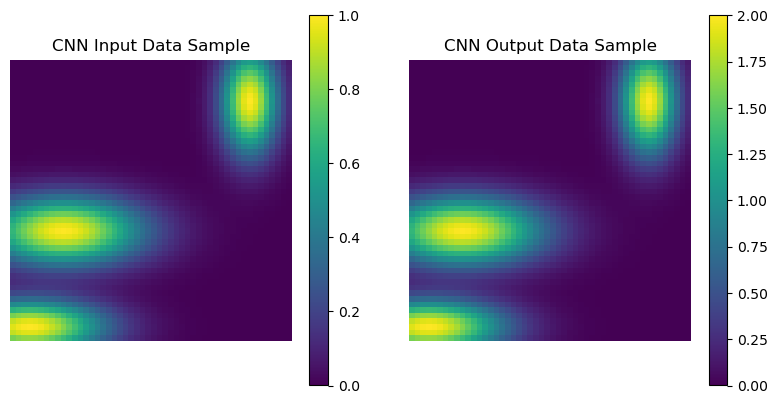

In [6]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].imshow(dataset_in[0])
axes[0].set_title("CNN Input Data Sample")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].imshow(dataset_out[0])
axes[1].set_title("CNN Output Data Sample")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()


## Custom Loss Function

In [7]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.alpha = alpha 
        self.beta = beta

    def forward(self, outputs, targets):
        output_fft = torch.fft.fft2(outputs)
        output_fft_max = output_fft.abs().max()
        target_fft = torch.fft.fft2(targets)
        target_fft_max = target_fft.abs().max()
        output_fft_normalized = output_fft / output_fft_max
        target_fft_normalized = target_fft / target_fft_max
        loss_fft = torch.mean(torch.abs(output_fft_normalized - target_fft_normalized) ** 2)
        loss_real = torch.mean((outputs - targets) ** 2)
        loss_total = self.beta * loss_real + self.alpha * loss_fft
        return loss_total

## CNN Training

In [12]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale, num of output channels

# Instantiate the model with the parameters
model = SimpleCNN(in_channels, image_height, image_width, output_channels)

# Check the model architecture
print(model)

# Loss criterion and optimizer
criterion = CustomLoss(beta=1.0, alpha=0.1)  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.0001) #, weight_decay=0.01)

# Define the number of input channels 
input_channels = 1
train_dataset = TensorDataset(training_NN_inputs, input_channels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

val_dataset = TensorDataset(val_NN_inputs, input_channels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

num_epochs = 100  # Number of epochs to train
loss_values = []  # Training loss for each epoch
val_loss_values = []  # Validation loss for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Batch size 1 handling (inputs shape: [1, y, x, variables ])
        inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Reshape to (vars, y, x) --> CNN input expects vars/channels first
        targets = targets.squeeze(0).float()  # Shape: (y, x)
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)

    # Validation phase: Use evaluate_model
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    val_loss_values.append(val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete!")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2500, bias=True)
)
Epoch [1/100], Training Loss: 0.4157, Validation Loss: 0.3559
Epoch [2/100], Training Loss: 0.3130, Validation Loss: 0.2785
Epoch [3/100], Training Loss: 0.2588, Validation Loss: 0.2543
Epoch [4/100], Training Loss: 0.2417, Validation Loss: 0.2471
Epoch [5/100], Training Loss: 0.2336, Validation Loss: 0.2411
Epoch [6/100], Training Loss: 0.2248, Validation Loss: 0.2295
Epoch [7/100], Training Loss: 0.2146, Validation Loss: 0.2197
Epoch [8/100], Training Loss: 0.2028, Validation Loss: 0.2044
Epoch [9/100], Training Loss: 0.1894, Validation Loss: 0.1905
Epoch [10/100], Training Loss: 0.1767, Validation Loss: 0.1753
Epoch [11/

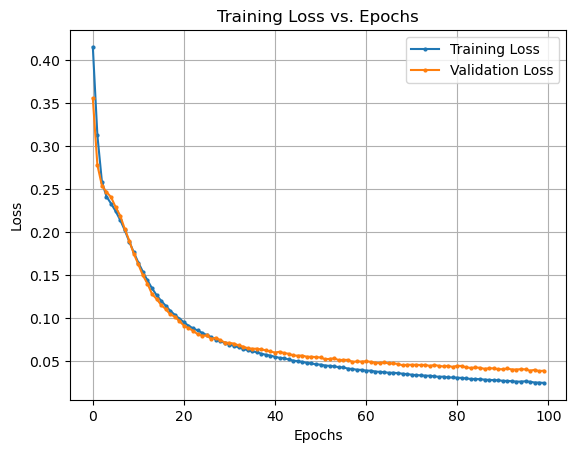

In [13]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Testing CNN

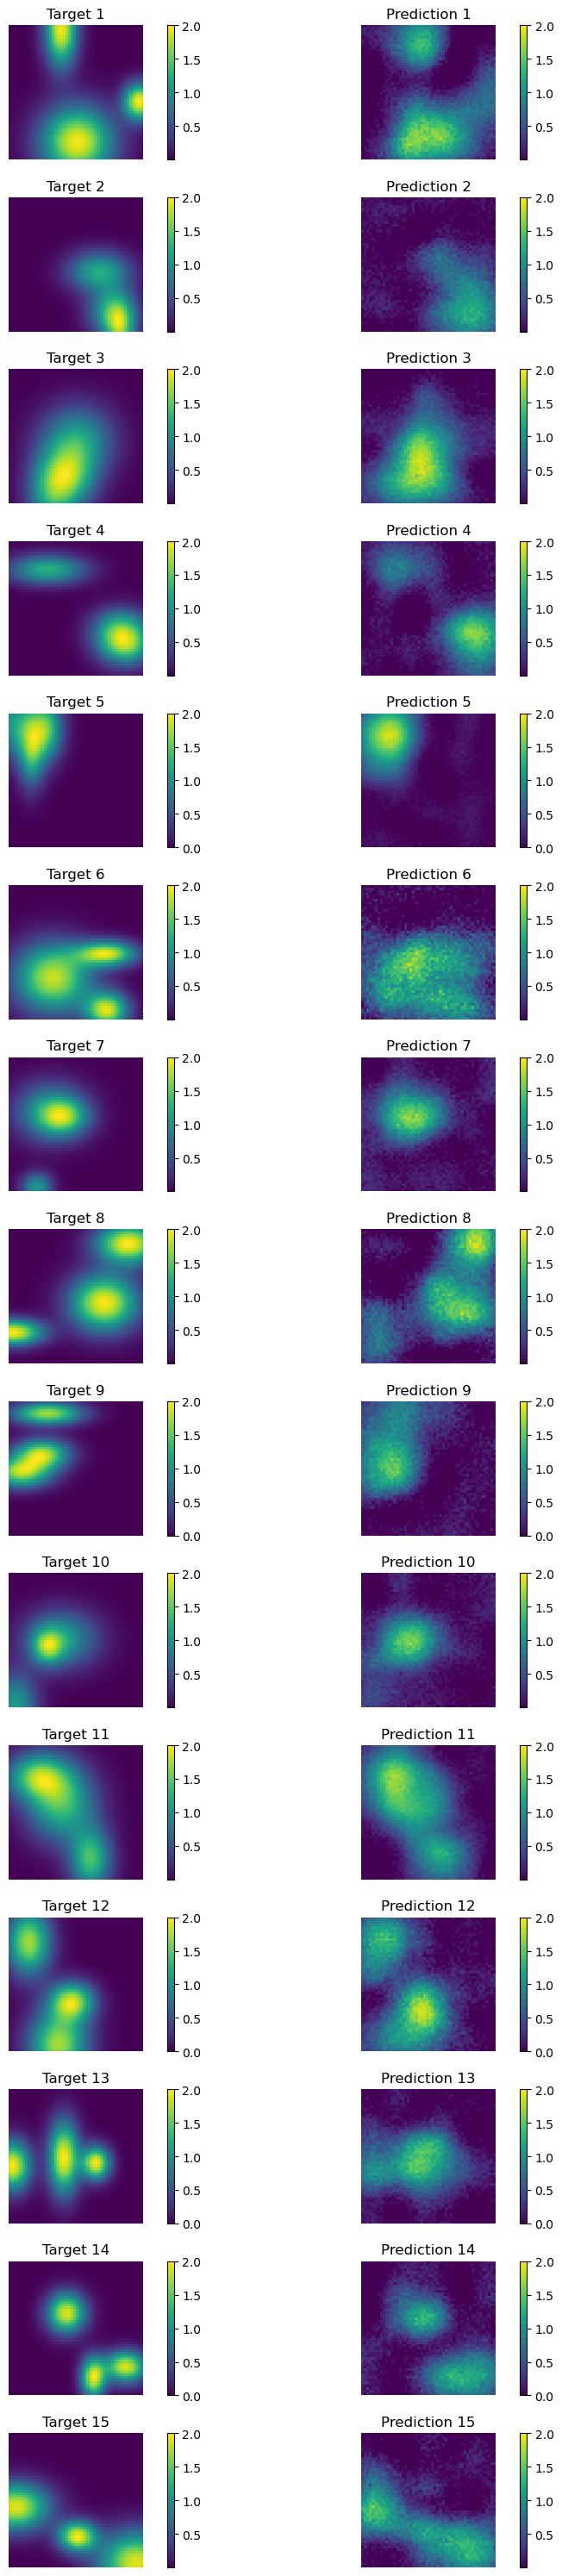

In [14]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs, input_channels)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

# Define your criterion (loss function)
criterion = CustomLoss(beta=1.0, alpha=0.1)  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=test_data_in.shape[0])  # Change num_samples as needed

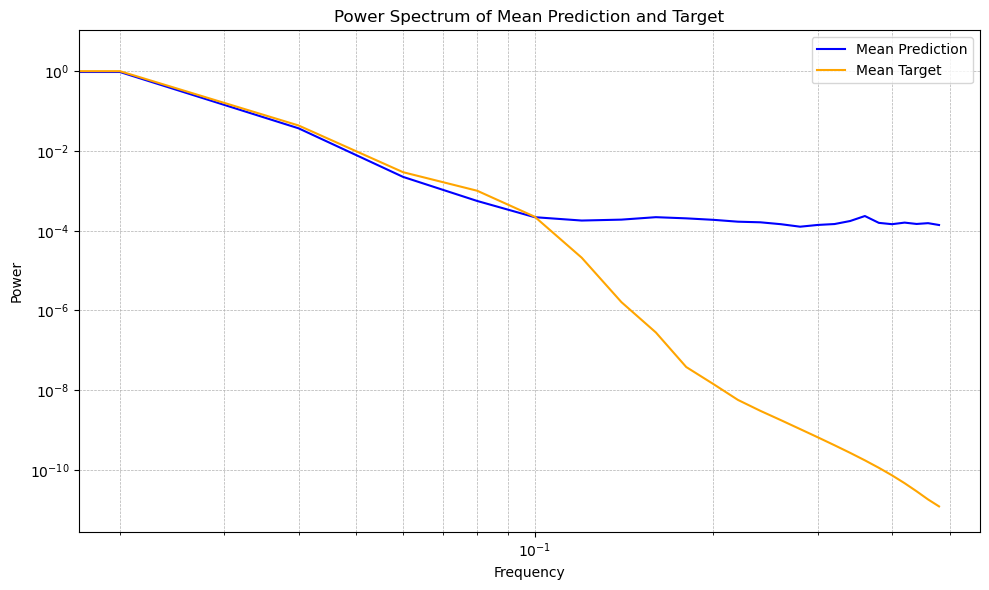

In [15]:
# Define dimensions and coordinates
dims = ['y', 'x']
coords = {
    'y': range(predictions.shape[-2]),  # Replace with actual coordinates if available
    'x': range(predictions.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = predictions.squeeze(1).mean(dim=0)  # Squeeze to remove the channel dimension and compute mean
mean_target = targets.mean(dim=0)

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction.numpy(), dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target.numpy(), dims=dims, coords=coords)

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='x', window=True).mean(dim='y')
ps_targ = xrft.power_spectrum(mean_target_da, dim='x', window=True).mean(dim='y')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_x, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_x, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()
